这个部分主要用于处理EMNIST数据来进行一定程度的数据增广

mapping file:
映射表

label file:
label指代的是每个图片所代表的字符

ubyte file:
balanced set: 里面包含了EMNIST测试集的图像数据
byclass set: 包含了按类划分的图像数据
bymerge set: 存储了合并字符的图像数据
digits set: 存储了数字的图像数据
letter set: 存储了单一字母的图像数据
Mnist set: 存储了 MNIST 训练机图像数据

因此为了满足需求，我目前只需要处理 Digits set 以及 letter set 将他们提取出来


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import requests
import re
import cv2
import os
from PIL import Image
import random
import torch

以下是数据预处理部分包括BHMSD，EMNIST，以及语料库（了不起的盖茨比）

注意！！请勿再运行保存图片的部分程序，这会导致部分图片重合甚至混乱！！

In [2]:
# Load the image data
def load_emnist_images(file_path):
    with open(file_path, 'rb') as f:
        # 读取前16个字节并解包为4个无符号整数 （因为每个整数都有4个字节，一共4个所以要读前16位）
        magic, num_images, num_rows, num_cols = struct.unpack(">IIII", f.read(16))
        # 读取剩余的数据并转换为8位无符号整数 （内容是实际图像数据范围是 0-255， 一个像素点一个byte）
        images = np.fromfile(f, dtype = np.uint8).reshape(num_images, num_rows, num_cols)
        # 调整图像通道顺序，确保按照正常方式排列
        images = np.swapaxes(images, 1, 2)
    return images

In [3]:
# Load the label data
def load_emnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack("II", f.read(8))
        # 读取剩余的数据并转换为8位无符号整数（内容是实际标签数据，一个标签一个字节）
        labels = np.fromfile(f, dtype = np.uint8)
    return labels

In [4]:
# 定义digits数据集路径
digits_images_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-train-images-idx3-ubyte"
digits_labels_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-train-labels-idx1-ubyte"
digits_images_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-test-images-idx3-ubyte"
digits_labels_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-test-labels-idx1-ubyte"

In [5]:
# 加载图片和标签数据
digits_images_train = load_emnist_images(digits_images_train_path)
digits_labels_train = load_emnist_labels(digits_labels_train_path)
digits_images_test = load_emnist_images(digits_images_test_path)
digits_labels_test = load_emnist_labels(digits_labels_test_path)

Image shape: (28, 28)


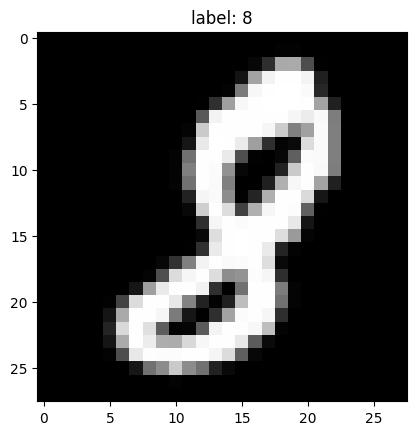

In [12]:
# 尝试打印第一张图片以及标签 (以train set测试)
first_digit_image = digits_images_train[0]
first_digit_label = digits_labels_train[0]

print(f"Image shape: {first_digit_image.shape}")

# 显示图片
plt.imshow(first_digit_image, cmap="gray")
plt.title(f"label: {first_digit_label}")
plt.show()

In [6]:
# 同样方法处理letters数据集

# 定义letters数据集路径
letters_images_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-train-images-idx3-ubyte"
letters_labels_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-train-labels-idx1-ubyte"
letters_images_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-test-images-idx3-ubyte"
letters_labels_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-test-labels-idx1-ubyte"

In [7]:
# 加载图片和标签
letters_images_train = load_emnist_images(letters_images_train_path)
letter_images_test = load_emnist_images(letters_images_test_path)
letters_labels_train = load_emnist_labels(letters_labels_train_path)
letters_labels_test = load_emnist_labels(letters_labels_test_path)

Image shape: (28, 28)


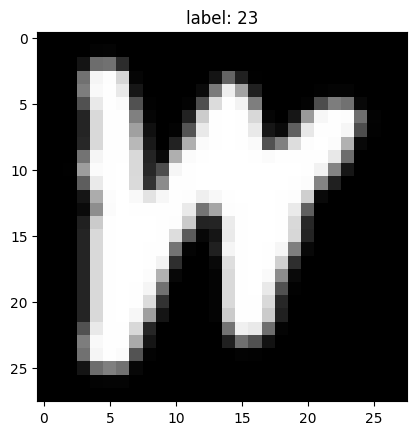

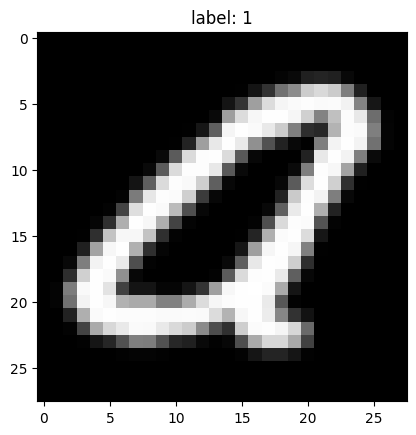

In [15]:
first_letter_image = letters_images_train[0]
first_letter_label = letters_labels_train[0]

print(f"Image shape: {first_letter_image.shape}")

# 显示图片
plt.imshow(first_letter_image, cmap="gray")
plt.title(f"label: {first_letter_label}")
plt.show()

# 打印label为1的图片
# 找到第一个label为1的图片
first_one_index = np.where(letters_labels_train == 1)[0][0]
first_one_image = letters_images_train[first_one_index]

# 显示图片
plt.imshow(first_one_image, cmap="gray")
plt.title(f"label: 1")
plt.show()

In [21]:
# 打印所有的字母label

print("Letter labels:")
print(np.unique(letters_labels_train))

Letter labels:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


从labels可见对应的是
a -> 1
b -> 2
.
.
.
z -> 26

In [8]:
# 定义bycalss path (upper-case)
byclass_images_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-byclass-train-images-idx3-ubyte"
byclass_labels_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-byclass-train-labels-idx1-ubyte"
byclass_images_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-byclass-test-images-idx3-ubyte"
byclass_labels_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-byclass-test-labels-idx1-ubyte"

# 加载图片和标签
byclass_images_train = load_emnist_images(byclass_images_train_path)
byclass_images_test = load_emnist_images(byclass_images_test_path)
byclass_labels_train = load_emnist_labels(byclass_labels_train_path)
byclass_labels_test = load_emnist_labels(byclass_labels_test_path)

In [10]:
byclass_labels_test.max()

61

In [1]:
# 将大写字母的图片存入目标文件夹

# 定义目标文件夹路径
base_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/"

# 读取mapping文件，定义mapping
f_name = '/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-byclass-mapping.txt'
with open(f_name, 'r') as f:
    mapping = f.read().splitlines()
map
# print(mapping)

# counter_upper = 0
# # 保存大写字母图片到目标文件夹 (train set)
# for i in range(len(byclass_labels_train)):
#     if byclass_labels_train[i] in uppercase_labels:
#         image = byclass_images_train[i]
#         character = chr(byclass_labels_train[i]+55)
#         # 定义新图片路径 以ASCII码为文件名
#         output_path = os.path.join(Letters_Upper_folder, character, f"{i}.png")
#         # 保存图片
#         cv2.imwrite(output_path, image)
#         # 计数
#         counter_upper += 1
    
    
# print("大写字母已经保存到目标文件夹")
# print(counter_upper)

['0 48', '1 49', '2 50', '3 51', '4 52', '5 53', '6 54', '7 55', '8 56', '9 57', '10 65', '11 66', '12 67', '13 68', '14 69', '15 70', '16 71', '17 72', '18 73', '19 74', '20 75', '21 76', '22 77', '23 78', '24 79', '25 80', '26 81', '27 82', '28 83', '29 84', '30 85', '31 86', '32 87', '33 88', '34 89', '35 90', '36 97', '37 98', '38 99', '39 100', '40 101', '41 102', '42 103', '43 104', '44 105', '45 106', '46 107', '47 108', '48 109', '49 110', '50 111', '51 112', '52 113', '53 114', '54 115', '55 116', '56 117', '57 118', '58 119', '59 120', '60 121', '61 122']


以下是将所有的源文件转化成图片并保存到指定文件夹

In [18]:
# 将大写字母的图片存入目标文件夹

# 定义目标文件夹路径
Letters_Upper_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Upper"

# 定义大写字母的标签范围 (因为A-Z是10-35在Byclass中)
uppercase_labels = list(range(10, 36))

# 在Upper_Letters文件夹中创建 A-Z 26个文件夹分别用来存放 A-Z 的图片
for i in range(26):
    folder_name = chr(i+65)
    folder_path = os.path.join(Letters_Upper_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)

counter_upper = 0
# 保存大写字母图片到目标文件夹 (train set)
for i in range(len(byclass_labels_train)):
    if byclass_labels_train[i] in uppercase_labels:
        image = byclass_images_train[i]
        character = chr(byclass_labels_train[i]+55)
        # 定义新图片路径 以ASCII码为文件名
        output_path = os.path.join(Letters_Upper_folder, character, f"{i}.png")
        # 保存图片
        cv2.imwrite(output_path, image)
        # 计数
        counter_upper += 1
    
    
print("大写字母已经保存到目标文件夹")
print(counter_upper)

大写字母已经保存到目标文件夹
188958


In [19]:
# 保存大写字母图片到目标文件夹 (test set)
for i in range(len(byclass_labels_test)):
    if byclass_labels_test[i] in uppercase_labels:
        image = byclass_images_test[i]
        character = chr(byclass_labels_test[i]+55)
        output_path = os.path.join(Letters_Upper_folder, character, f"{i+counter_upper}.png")
        cv2.imwrite(output_path, image)

print("大写字母已经保存到目标文件夹")

大写字母已经保存到目标文件夹


In [12]:
# 将小写字母的图片存入目标文件夹

# 定义目标文件夹路径
Letters_Lower_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Lower"

# 定义小写字母的标签范围 (因为a-z是36-61在Byclass中)
lowercase_labels = list(range(36, 62))

# 在Lower_Letters文件夹中创建 a-z 26个文件夹分别用来存放a-z 的图片
for i in range(26):
    folder_name = chr(i+97)
    folder_path = os.path.join(Letters_Lower_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)

counter_lower = 0
# 保存小写字母图片到目标文件夹 (train set)
for i in range(len(byclass_labels_train)):
    if byclass_labels_train[i] in lowercase_labels:
        image = byclass_images_train[i]
        character = chr(byclass_labels_train[i]+61)
        # 定义新图片路径 以ASCII码为文件名
        output_path = os.path.join(Letters_Lower_folder, character, f"{i}.png")
        # 保存图片
        cv2.imwrite(output_path, image)
        # 计数
        counter_lower += 1
    
    
print("小写字母已经保存到目标文件夹")
print(counter_lower)

小写字母已经保存到目标文件夹
163939


In [15]:
# 处理小写字母的测试集

# 保存小写字母图片到目标文件夹 (test set)
for i in range(len(byclass_labels_test)):
    if byclass_labels_test[i] in lowercase_labels:
        image = byclass_images_test[i]
        character = chr(byclass_labels_test[i]+61)
        # 定义新图片路径 以ASCII码为文件名
        output_path = os.path.join(Letters_Lower_folder, character, f"{i+counter_lower}.png")
        # 保存图片
        cv2.imwrite(output_path, image)

print("小写字母测试集已经保存到目标文件夹")

小写字母测试集已经保存到目标文件夹


In [21]:
# 将数字图片存入目标文件夹

# 定义目标文件夹路径
Digits_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Digits"

# 在Digits文件夹中创建 0-9 10个文件夹分别用来存放 0-9 的图片
for i in range(10):
    folder_name = str(i)
    folder_path = os.path.join(Digits_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)

counter_digits = 0
# 保存数字图片到目标文件夹 (train set)
for i in range(len(digits_labels_train)):
    image = digits_images_train[i]
    character = str(digits_labels_train[i])
    # 定义新图片路径 以ASCII码为文件名
    output_path = os.path.join(Digits_folder, character, f"{i}.png")
    # 保存图片
    cv2.imwrite(output_path, image)
    # 记录counter防止后面增加test时重复
    counter_digits += 1

print("数字已经保存到目标文件夹")

数字已经保存到目标文件夹


In [22]:
# 保存数字图片到目标文件夹 (test set)
for i in range(len(digits_labels_test)):
    image = digits_images_test[i]
    character = str(digits_labels_test[i])
    # 定义新图片路径 以ASCII码为文件名
    output_path = os.path.join(Digits_folder, character, f"{i+counter_digits}.png")
    # 保存图片
    cv2.imwrite(output_path, image)

In [2]:
# 尝试读取 https://www.gutenberg.org/cache/epub/64317/pg64317.txt 内容

# 下载网页文件
url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt"
response = requests.get(url)
text = response.text

# 初始化变量
word_count = 0
paragraphs = []
current_paragraph = ''
current_word = ''

counter_paragraph = 0
# 每90个单词组成一个段落
for char in text:
    if char.isalnum():
        current_word += char
    else:
        if current_word:
            word_count += 1
            current_paragraph += current_word
            current_word = ''
        if char == '\n':
            current_paragraph += '\n'
        elif char == '\r':
            continue  # 忽略 '\r' 符号，因为 '\n' 已经处理了换行
        elif re.match(r'[^\w\s]', char) or char == ' ':
            current_paragraph += char
    
    # 每90个单词形成一个段落
    if word_count == 90:
        paragraphs.append(current_paragraph)
        current_paragraph = ''
        word_count = 0
        counter_paragraph += 1


# 将最后剩余的部分（不超过90个词）添加到paragraph
if current_paragraph or current_word:
    current_paragraph += current_word
    paragraphs.append(current_paragraph)

for i in range(10):
    print(paragraphs[i])
    print("\n")

print(counter_paragraph)

print(len(paragraphs))

The Project Gutenberg eBook of The Great Gatsby
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before 


using this eBook.

Title: The Great Gatsby

Author: F. Scott Fitzgerald

Release date: January 17, 2021 [eBook #64317]
                Most recently updated: February 2, 2024

Language: English

Credits: Produced by Alex Cabal for the Standard Ebooks project, based on a transcription produced for Project Gutenberg Australia.


*** START OF THE PROJECT GUTENBERG EBOOK THE GREAT GATSBY ***




                           The Great Gatsby
                                  by
                          F. Scott Fitzgera

In [3]:
# 为了避免出现特殊字符，所以在此定义字母和数字

# 定义大写字母
uppercase = [chr(i) for i in range(65, 91)]

# 定义小写字母
lowercase = [chr(i) for i in range(97, 123)]

# 定义数字
digits = [i for i in range(10)]

print(uppercase)
print(lowercase)
print(digits)

# 将paragraph中除了字母，数字，句号，换行符号之外的字符替换为空格

# 初始化变量
processed_paragraphs = []

# 替换paragraph中的特殊字符
for paragraph in paragraphs:
    processed_paragraph = ''
    for char in paragraph:
        if char in uppercase or char in lowercase or char in digits or char == '.' or char == '\n' or char == ' ':
            processed_paragraph += char
        else:
            processed_paragraph += ' '
    processed_paragraphs.append(processed_paragraph)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
for i in range(10):
    print(f"The {i} paragraph:")
    print(processed_paragraphs[i])
    print("\n")

The 0 paragraph:
 The Project Gutenberg eBook of The Great Gatsby
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it  give it away or re use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States 
you will have to check the laws of the country where you are located
before 


The 1 paragraph:
using this eBook.

Title  The Great Gatsby

Author  F. Scott Fitzgerald

Release date  January           eBook        
                Most recently updated  February        

Language  English

Credits  Produced by Alex Cabal for the Standard Ebooks project  based on a transcription produced for Project Gutenberg Australia.


    START OF THE PROJECT GUTENBERG EBOOK THE GREAT GATSBY    




                           The Great Gatsby
                                  by
        

下一步就准备尝试匹配上面一个paragraph，并生成对应图像
在此声明BHMSD （图片开头即为该图片的图像数据）：
0-9
dot -> 句号
minu
plus
slash
w
x
y
z

In [ ]:
# 检查一下BHMSD的图片大小和EMNIST的图片大小是否一致

# 定义BHMSD数据集路径
BHMSD_Images_folder = "/root/autodl-tmp/APS360_Project/Datasets/BHMSD_Unzip/bhmsds/symbols"

# 获取第一张图片的大小
BHMSD_image_path = "/root/autodl-tmp/APS360_Project/Datasets/BHMSD_Unzip/bhmsds/symbols/0-0000.png"
BHMSD_image = Image.open(BHMSD_image_path)

# 计算图片size
BHMSD_image_size = BHMSD_image.size

# 检查EMNIST的图片大小
EMNIST_image_size = first_digit_image.shape

print(f"BHMSD image size: {BHMSD_image_size}")
print(f"EMNIST image size: {EMNIST_image_size}")

In [18]:
# 由上方可以证明BHMSD的图片大小和EMNIST的图片大小是一致的，都是 28x28

# 因为BHMSD的图片是白色底部黑色字体，而EMNIST的图片是黑色底部白色字体，所以需要对EMNIST的图片进行处理

# 已知三者文件夹名字为：Digits, Letters_Upper, Letters_Lower
# 路径变量为：Digits_folder, Letters_Upper_folder, Letters_Lower_folder

# 将EMNIST的图片转换为白底黑字体并覆盖原本的图片
Digits_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Digits"

# 遍历主文件夹的子文件夹
for root, dirs, files in os.walk(Digits_folder):
    for file in files:
        if file.endswith(".png"):
            # 读取图片
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # 反转颜色
            image = 255 - image
            # 保存图片
            cv2.imwrite(image_path, image)

print("Digits folder done")


Digits folder done


In [20]:
# 转换大写字母
Letters_Upper_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Upper"

# 遍历主文件夹的子文件夹
for root, dirs, files in os.walk(Letters_Upper_folder):
    for file in files:
        if file.endswith(".png"):
            # 读取图片
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # 反转颜色
            image = 255 - image
            # 保存图片
            cv2.imwrite(image_path, image)

print("Uppercase folder done")

Uppercase folder done


In [21]:
# 转换小写字母
Letters_Lower_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Lower"

# 遍历主文件夹的子文件夹
for root, dirs, files in os.walk(Letters_Lower_folder):
    for file in files:
        if file.endswith(".png"):
            # 读取图片
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # 反转颜色
            image = 255 - image
            # 保存图片
            cv2.imwrite(image_path, image)

print("Lowercase folder done")

Lowercase folder done


接下来就准备开始根据paragraph从处理好的文件夹中提取图片并生成图片

In [6]:
# 定义BHMSD数据集路径
BHMSD_Images_folder = "/root/autodl-tmp/APS360_Project/Datasets/BHMSD_Unzip/bhmsds/symbols"

# 已知剩余三者文件夹名字为：Digits, Letters_Upper, Letters_Lower
# 路径变量为：Digits_folder, Letters_Upper_folder, Letters_Lower_folder
# counter_paragraph 为总共的段落数量

In [6]:
# 创建一个函数用于把图像放置在大的图片上
def place_char_image(paragraph_img, char_img, x, y):
    # 确保没超出界限
    if y + char_img.shape[0] <= paragraph_img.shape[0] and x + char_img.shape[1] <= paragraph_img.shape[1]:
        paragraph_img[y:y + char_img.shape[0], x:x + char_img.shape[1]] = char_img


In [7]:
# 定义目标文件夹路径
Data_augmentation_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation"

# 定义源文件夹路径
Digits_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Digits"
Letters_Upper_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Upper"
Letters_Lower_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Lower"
BHMSD_Images_folder = "/root/autodl-tmp/APS360_Project/Datasets/BHMSD_Unzip/bhmsds/symbols"

# 初始化图片的大小
line_height = 28
max_width = 3600  # 一行最大宽度

In [8]:
def generate_position_labels(paragraph):
    labels = []

    current_x = random.randint(20, 30)
    current_y = random.randint(20, 30)

    temp_word = ""
    temp_start_x = 0

    for char in paragraph:
        space_width = random.randint(20, 30)
        
        if char == ' ' or char == '\n':
            if temp_word:
                labels.append([temp_start_x, current_y, current_x - temp_start_x, line_height])
                temp_word = ""
            if char == ' ':
                current_x += space_width
            if char == '\n':
                current_x = random.randint(20, 30)
                current_y += line_height + random.randint(20, 35)
        
        elif char == '.':
            if temp_word:
                labels.append([temp_start_x, current_y, current_x - temp_start_x, line_height])
                temp_word = ""
            labels.append([current_x, current_y + 20, 10, 10])
            current_x += 10 + space_width
        
        else:
            if not temp_word:
                temp_start_x = current_x
            temp_word += char
            current_x += 28

    if temp_word:
        labels.append([temp_start_x, current_y, current_x - temp_start_x, line_height])
        
    return labels


In [9]:
# 生成文本标签
def generate_text_labels(paragraph):
    labels = []
    temp_word = ""

    for char in paragraph:
        if char == ' ' or char == '\n' or char == '.':
            if temp_word:
                labels.append(temp_word)
                temp_word = ""
            if char == '.':
                labels.append('.')
        else:
            temp_word += char

    # 如果有剩余的单词，将其存入labels   
    if temp_word:
        labels.append(temp_word)

    return labels

In [10]:
def crop_and_resize_image(image, labels, target_size = 1024):
    min_x = min([label[0] for label in labels])
    min_y = min([label[1] for label in labels])
    max_x = max([label[0] + label[2] for label in labels])
    max_y = max([label[1] + label[3] for label in labels])

    crop_image = image[min_y:max_y, min_x:max_x]
    padding = random.randint(25, 40)
    size = max(crop_image.shape) + padding * 2

    final_image = np.ones((size, size), dtype=np.uint8) * 255

    # 计算开始位置
    start_x = (size - crop_image.shape[1]) // 2
    start_y = (size - crop_image.shape[0]) // 2
    final_image[start_y:start_y + crop_image.shape[0], start_x:start_x + crop_image.shape[1]] = crop_image

    for label in labels:
        # 减去最小值，然后加上开始位置
        label[0] = (label[0] - min_x + start_x) * target_size / size
        label[1] = (label[1] - min_y + start_y) * target_size / size
        label[2] = label[2] * target_size / size
        label[3] = label[3] * target_size / size
    
    final_image = cv2.resize(final_image, (target_size, target_size))
    return final_image, labels


In [12]:
Digits_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Digits"
Letters_Upper_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Upper"
Letters_Lower_folder = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_Processed/Letters_Lower"
BHMSD_Images_folder = "/root/autodl-tmp/APS360_Project/Datasets/BHMSD_Unzip/bhmsds/symbols"
Data_augmentation_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation"
Position_labels_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/Data_augmentation_position_labels"
Text_labels_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/Data_augmentation_text_labels"

digits_files = [os.listdir(os.path.join(Digits_folder, str(i))) for i in range(10)]
lower_files = {chr(i): os.listdir(os.path.join(Letters_Lower_folder, chr(i))) for i in range(97, 123)}
upper_files = {chr(i): os.listdir(os.path.join(Letters_Upper_folder, chr(i))) for i in range(65, 91)}

counter = 0
# 遍历所有的段落
for paragraph in paragraphs:
    paragraph_image = np.ones((line_height * 120, max_width), dtype=np.uint8) * 255

    position_labels = generate_position_labels(paragraph)
    text_labels = generate_text_labels(paragraph)

    for (start_x, start_y, width, height), word in zip(position_labels, text_labels):
        for char in word:
            char_image_path = None
            char_image = None

            if char in digits:
                char_image_path = os.path.join(Digits_folder, char, np.random.choice(digits_files[int(char)]))
            elif char in uppercase:
                char_image_path = os.path.join(Letters_Upper_folder, char, np.random.choice(upper_files[char]))
            elif char in lowercase:
                char_image_path = os.path.join(Letters_Lower_folder, char, np.random.choice(lower_files[char]))
            elif char == '.':
                Images = [f for f in os.listdir(BHMSD_Images_folder) if f.startswith("dot")]
                if Images:
                    char_image_path = os.path.join(BHMSD_Images_folder, np.random.choice(Images))
                    char_image = cv2.imread(char_image_path, cv2.IMREAD_GRAYSCALE)
                    char_image = cv2.resize(char_image, (10, 10))
            
            if char_image_path and os.path.exists(char_image_path):
                if char_image is None:
                    char_image = cv2.imread(char_image_path, cv2.IMREAD_GRAYSCALE)
                if char_image is not None:
                    place_char_image(paragraph_image, char_image, start_x, start_y)
                    start_x += char_image.shape[1]

    crop_image, updated_labels = crop_and_resize_image(paragraph_image, position_labels)

    counter += 1

    image_saved_path = os.path.join(Data_augmentation_folder, f"{counter}.png")
    cv2.imwrite(image_saved_path, crop_image)

    position_labels_tensor = torch.tensor(updated_labels)
    torch.save(position_labels_tensor, os.path.join(Position_labels_folder, f"{counter}.pt"))
    torch.save(text_labels, os.path.join(Text_labels_folder, f"{counter}.pt"))

    print(f"Saved augmented data for paragraph {counter}")

print("Data augmentation done")

Saved augmented data for paragraph 1
Saved augmented data for paragraph 2
Saved augmented data for paragraph 3
Saved augmented data for paragraph 4
Saved augmented data for paragraph 5
Saved augmented data for paragraph 6
Saved augmented data for paragraph 7
Saved augmented data for paragraph 8
Saved augmented data for paragraph 9
Saved augmented data for paragraph 10
Saved augmented data for paragraph 11
Saved augmented data for paragraph 12
Saved augmented data for paragraph 13
Saved augmented data for paragraph 14
Saved augmented data for paragraph 15
Saved augmented data for paragraph 16
Saved augmented data for paragraph 17
Saved augmented data for paragraph 18
Saved augmented data for paragraph 19
Saved augmented data for paragraph 20
Saved augmented data for paragraph 21
Saved augmented data for paragraph 22
Saved augmented data for paragraph 23
Saved augmented data for paragraph 24
Saved augmented data for paragraph 25
Saved augmented data for paragraph 26
Saved augmented data 

接下来我会打包所有的图像文件以及标签文件，将他们合并成几个总的pt文件

In [14]:
def pack_pt_files(source_folder, output_file):
    all_tensors = []
    for file in sorted(os.listdir(source_folder)):
        if file.endswith('.pt'):
            file_path = os.path.join(source_folder, file)
            tensor = torch.load(file_path)
            all_tensors.append(tensor)
    torch.save(all_tensors, output_file)
    print(f"Saved to {output_file}")

In [15]:
def pack_png_files(source_folder, output_file):
    all_images = []
    for file in sorted(os.listdir(source_folder)):
        if file.endswith('.png'):
            file_path = os.path.join(source_folder, file)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            image_tensor = torch.tensor(image, dtype = torch.float32).unsqueeze(0)
            all_images.append(image_tensor)
    torch.save(all_images, output_file)
    print(f"Saved to {output_file}")

In [13]:
# 定义输入和输出路径
Position_labels_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/Data_augmentation_position_labels"
Text_labels_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/Data_augmentation_text_labels"
Images_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation"

position_labels_output_file = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/seg_label_train.pt"
text_labels_output_file = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/rec_label_train.pt"
image_output_file = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/seg_data_train.pt"

In [52]:
# 打包pt文件
pack_pt_files(Position_labels_folder, position_labels_output_file)
pack_pt_files(Text_labels_folder, text_labels_output_file)

# 打包png文件
pack_png_files(Images_folder, image_output_file)

Saved to /root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/seg_label_train.pt
Saved to /root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/rec_label_train.pt
Saved to /root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/seg_data_train.pt


In [14]:
# 根据标签文件，裁剪出每个段落图片中的每一个词语的图片，并保存到新的文件夹中

# 定义目标文件夹路径
Words_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation/Single_character_image"

# 处理一个段落的图片，并裁剪图像以及保存
def extract_save_words(paragraph_image_path, position_label_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image = cv2.imread(paragraph_image_path, cv2.IMREAD_GRAYSCALE)
    labels = torch.load(position_label_path)

    for index, (x, y, width, height) in enumerate(labels):
        # 将坐标转换为整数
        x, y, width, height = int(x), int(y), int(width), int(height)
        print(f"Processing word {index}: x={x}, y={y}, width={width}, height={height}")
        word_image = image[y : y + height, x : x + width]
        save_path = os.path.join(save_folder, f"{index}.png")
        if word_image.size != 0:  # Ensure the cropped image is not empty
            cv2.imwrite(save_path, word_image)
        else:
            print(f"Skipping empty image for word {index}")

    print(f"Saved to {save_folder}")

In [15]:
# 提取所有的段落图片和标签，并丢入extract_save_words函数中
def process_images(paragraph_folder, labels_folder, save_folder):
    paragraph_files = sorted([f for f in os.listdir(paragraph_folder) if f.endswith('.png')])
    label_files = sorted([f for f in os.listdir(labels_folder) if f.endswith('.pt')])

    for paragraph_file, label_file in zip(paragraph_files, label_files):
        paragraph_image_path = os.path.join(paragraph_folder, paragraph_file)
        position_label_path = os.path.join(labels_folder, label_file)
        # 创建独立文件夹
        word_save_folder = os.path.join(save_folder, os.path.splitext(paragraph_file)[0])
        extract_save_words(paragraph_image_path, position_label_path, word_save_folder)

In [16]:
process_images(Images_folder, Position_labels_folder, Words_folder)

Processing word 0: x=13, y=391, width=56, height=14
Processing word 1: x=81, y=391, width=98, height=14
Processing word 2: x=192, y=391, width=127, height=14
Processing word 3: x=330, y=391, width=70, height=14
Processing word 4: x=413, y=391, width=28, height=14
Processing word 5: x=456, y=391, width=42, height=14
Processing word 6: x=513, y=391, width=70, height=14
Processing word 7: x=596, y=391, width=84, height=14
Processing word 8: x=16, y=451, width=56, height=14
Processing word 9: x=84, y=451, width=70, height=14
Processing word 10: x=169, y=451, width=28, height=14
Processing word 11: x=212, y=451, width=42, height=14
Processing word 12: x=267, y=451, width=42, height=14
Processing word 13: x=322, y=451, width=42, height=14
Processing word 14: x=379, y=451, width=28, height=14
Processing word 15: x=421, y=451, width=84, height=14
Processing word 16: x=519, y=451, width=113, height=14
Processing word 17: x=646, y=451, width=28, height=14
Processing word 18: x=689, y=451, width=

现在我们需要将所有的生成的pt文件打包

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:
# 打包Data_augementation中的所有段落图片到一个大的pt文件
def pack_png_files(source_folder, output_folder):
    all_images = []
    for file in sorted(os.listdir(source_folder)):
        if file.endswith('.png'):
            file_path = os.path.join(source_folder, file)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            image_tensor = torch.tensor(image, dtype = torch.float32).unsqueeze(0)
            all_images.append(image_tensor)
            # 删除原文件
            os.remove(file_path)
    # Create the path of the saved file
    output_file = os.path.join(output_folder, "seg_data_train.pt")
    torch.save(all_images, output_file)
    print(f"Saved to {output_file}")

In [ ]:
source_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation"
output_folder = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation"

# 打包png文件
pack_png_files(source_folder, output_folder)

In [ ]:
class SegDataset(Dataset):
    def __init__(self, mode):
        self.path = "/root/autodl-tmp/APS360_Project/Datasets/Data_augmentation"
        self.name = "Data_augmentation"
        self.mode = mode
        self.data = torch

In [ ]:
class RecDataset(Dataset):
    def __init__(self, name, mode):


In [ ]:
# 调用utils.py中的类
from utils import SegDataset, RecDataset

# 实例化SegDataset
seg_dataset = SegDataset()

# 给对象赋值
